In [17]:
import numpy as np
import torch

In [18]:
np.random.seed(42)
torch.manual_seed(42)

In [19]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

datapath = 'data'

# load dataset
data_train = MNIST(
    root = datapath,
    train = True,                         
    transform = ToTensor(), 
)
data_test = MNIST(
    root = datapath, 
    train = False, 
    transform = ToTensor(),
)

In [20]:
# hyperparameters
batch_size = 16
lr = 1e-3
n_epochs = 100
train_val_split = [.8, .2]

In [21]:
from torch.utils.data import random_split

# torch.Generator() performs a random split, make sure you have set a manual_seed for reproducibility at the beginning of your code
# alternatively, you can use torch.Generator().manual_seed(42)
 
data_train, data_val = random_split(data_train, train_val_split, generator=torch.Generator())

In [22]:
print("Size of training dataset:", len(data_train))
print("Size of validation dataset:", len(data_val))

Size of training dataset: 48000
Size of validation dataset: 12000


In [23]:
x_sample, y_sample = data_val[0]

print("Shape of x_sample:", x_sample.shape)
print("y_sample is an integer:", type(y_sample))

Shape of x_sample: torch.Size([1, 28, 28])
y_sample is an integer: <class 'int'>


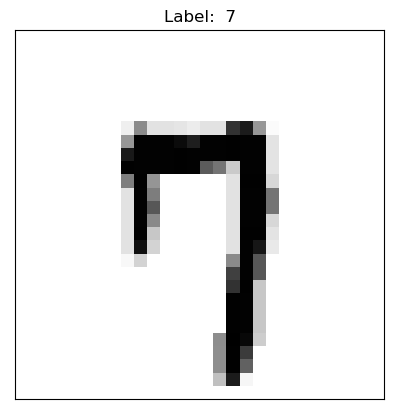

In [24]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(x_sample[0], cmap='binary')
plt.title(f'Label: {y_sample: d}')
plt.xticks([])
plt.yticks([])
plt.show()

In [25]:
import torch.nn as nn

class SimpleMLP(nn.Module):

    """
    - input_shape: shape of a single input data point
    """
    def __init__(self, input_shape, n_classes):
        super().__init__()
        self.input_shape = np.asarray(input_shape)
        self.n_classes = n_classes
        self.seq_model = nn.Sequential(
            nn.Linear(self.input_shape.prod(), 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, self.n_classes)
        )

    def forward(self, x):
        x = x.view(-1, self.input_shape.prod())  # make the input of shape (batch_size, height*weight)
        scores = self.seq_model(x)
        return scores
    
    # def __repr__(self):
    #     return "Overwritten print"


In [26]:
model = SimpleMLP(input_shape=(1, 28, 28), n_classes=10)
print(model)

SimpleMLP(
  (seq_model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
)


In [27]:
from torch.utils.data import DataLoader

train_loader = DataLoader(data_train, batch_size=16, shuffle=True)
test_loader = DataLoader(data_test, batch_size=16, shuffle=False)

In [28]:
x_batch, y_batch = next(iter(train_loader))
print("x_batch shape:", x_batch.shape)
print("y_batch shape:", y_batch.shape)

x_batch shape: torch.Size([16, 1, 28, 28])
y_batch shape: torch.Size([16])


In [29]:
pred_batch = model(x_batch)
print("Example of model's logits shape:", pred_batch.shape)

Example of model's logits shape: torch.Size([16, 10])


In [30]:
def model_accuracy(data_loader):
    n_total = 0
    n_correct = 0

    for x_batch, y_batch in data_loader:
        logits_batch = model(x_batch)  # model's output scores
        n_total += len(y_batch)
        n_correct += sum(logits_batch.argmax(axis=-1) == y_batch)
    return n_correct / n_total

print("Train accuracy before training:", model_accuracy(train_loader))
print("Test accuracy before training:", model_accuracy(test_loader))

Train accuracy before training: tensor(0.0716)
Test accuracy before training: tensor(0.0713)


In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [32]:
from tqdm import tqdm

n_epochs = 10
for _ in tqdm(range(n_epochs)):
    for x_batch, y_batch in train_loader:

        optimizer.zero_grad()
        logits_batch = model(x_batch)
        loss_batch = loss_fn(logits_batch, y_batch)
        loss_batch.backward()
        optimizer.step()

100%|██████████| 10/10 [01:32<00:00,  9.27s/it]


In [33]:
print("Train accuracy after training:", model_accuracy(train_loader))
print("Test accuracy after training:", model_accuracy(test_loader))

Train accuracy after training: tensor(0.9917)
Test accuracy after training: tensor(0.9723)
